In [1]:
import pandas as pd
import numpy as np
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import geopandas as gpd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rasterio
from rasterio.sample import sample_gen
from matplotlib.patches import Patch
from scipy.spatial.distance import cdist

from src.mplstyle import set as set_mplstyle
set_mplstyle("Fira Sans")

HADISD_PATH = Path("/mnt/d/climate_data/HadISD/")
HPD_PATH = Path("/mnt/d/climate_data/hpd/data/")
DATA_DOC_PATH = Path("./data/dataset_docs/")
OE_PATH = Path("/mnt/d/climate_data/HPD_CONUS_OEVENTS/")
ERA5_PATH = Path("/mnt/d/climate_data/ERA5_CONUS_STATIONS/")

OUTPUT_PATH = Path("./output/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

MERGED_OE_PATH = Path("./data/OE_dpt_era5/")
MERGED_OE_PATH.mkdir(parents=True, exist_ok=True)

KG_RASTER_PATH = Path("./data/CONUS_Beck_KG_V1_Present.tif")

KOPPEN_DATA = {
        1:  ('Af - Tropical, rainforest', [0, 0, 255]),
        2:  ('Am - Tropical, monsoon', [0, 120, 255]),
        3:  ('Aw - Tropical, savannah', [70, 170, 250]),
        4:  ('BWh - Arid, desert, hot', [255, 0, 0]),
        5:  ('BWk - Arid, desert, cold', [255, 150, 150]),
        6:  ('BSh - Arid, steppe, hot', [245, 165, 0]),
        7:  ('BSk - Arid, steppe, cold', [255, 220, 100]),
        8:  ('Csa - Temperate, dry summer, hot summer', [255, 255, 0]),
        9:  ('Csb - Temperate, dry summer, warm summer', [200, 200, 0]),
        10: ('Csc - Temperate, dry summer, cold summer', [150, 150, 0]),
        11: ('Cwa - Temperate, dry winter, hot summer', [150, 255, 150]),
        12: ('Cwb - Temperate, dry winter, warm summer', [100, 200, 100]),
        13: ('Cwc - Temperate, dry winter, cold summer', [50, 150, 50]),
        14: ('Cfa - Temperate, no dry season, hot summer', [200, 255, 80]),
        15: ('Cfb - Temperate, no dry season, warm summer', [100, 255, 80]),
        16: ('Cfc - Temperate, no dry season, cold summer', [50, 200, 0]),
        17: ('Dsa - Cold, dry summer, hot summer', [255, 0, 255]),
        18: ('Dsb - Cold, dry summer, warm summer', [200, 0, 200]),
        19: ('Dsc - Cold, dry summer, cold summer', [150, 50, 150]),
        20: ('Dsd - Cold, dry summer, very cold winter', [150, 100, 150]),
        21: ('Dwa - Cold, dry winter, hot summer', [170, 175, 255]),
        22: ('Dwb - Cold, dry winter, warm summer', [90, 120, 220]),
        23: ('Dwc - Cold, dry winter, cold summer', [75, 80, 180]),
        24: ('Dwd - Cold, dry winter, very cold winter', [50, 0, 135]),
        25: ('Dfa - Cold, no dry season, hot summer', [0, 255, 255]),
        26: ('Dfb - Cold, no dry season, warm summer', [55, 200, 255]),
        27: ('Dfc - Cold, no dry season, cold summer', [0, 125, 125]),
        28: ('Dfd - Cold, no dry season, very cold winter', [0, 70, 95]),
        29: ('ET - Polar, tundra', [178, 178, 178]),
        30: ('EF - Polar, frost', [102, 102, 102])
    }

# PRCP - DPT stations

In [2]:
# hadisd_stations = pd.read_csv(DATA_DOC_PATH/"hadisd_station_info_v342_202503p.txt", delimiter='\s+', names=["WMO-ID", "Lat", "Lon", "Elev"])
hpd_stations = (
    pd.read_csv(DATA_DOC_PATH / "HPD_v02r02_stationinv_c20240502.csv")
    .drop(columns=['Last_Half_POR', 'PCT_Last_Half_Good', 'Last_Qtr_POR', 'PCT_Last_Qtr_Good', 'Sample_Interval (min)', 'WMO_ID'])
)

hadisd_stations = pd.read_fwf(DATA_DOC_PATH/"hadisd_station_fullinfo_v342_202501p.txt", 
                              colspecs=[(0, 12), (13, 43), (44, 50), (52, 59), (62, 67), (69, 79), (80, 90)],
                              names=["WMO-ID", "Name", "Lat", "Lon", "Elev", "Start", "End"])
hadisd_stations = hadisd_stations.query("(-125 <= Lon <= -66.75) and (24.5 <= Lat <= 49.5)")
potential_stations = hpd_stations.query("24.5 < Lat < 49.5 and -125 < Lon < -66.75")

In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    Returns distance in kilometers
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    r = 6371 # Radius of earth in kilometers
    return c * r


def find_nearest_dpt_stations(potential_stations, hadisd_stations, 
                                                max_distance_km=40, max_elevation_diff_m=50, pick_longest=True):

    """
    Find the nearest temperature station for each precipitation station
    subject to distance and elevation constraints.
    
    Parameters:
    - potential_stations: DataFrame with precipitation stations (Lat, Lon, Elev)
    - hadisd_stations: DataFrame with temperature stations (Lat, Lon, Elev)
    - max_distance_km: Maximum allowed distance in kilometers (default: 40)
    - max_elevation_diff_m: Maximum allowed elevation difference in meters (default: 50)
    - pick_longest: If True, pick the station with the longest coverage among the valid stations
    
    Returns:
    - DataFrame with matched stations
    """
    
    # Convert to numpy arrays for vectorized operations
    precip_id = potential_stations['StnID'].values
    dpt_id = hadisd_stations['WMO-ID'].values

    precip_coords = potential_stations[['Lat', 'Lon']].values
    dpt_coords = hadisd_stations[['Lat', 'Lon']].values

    precip_elevs = potential_stations['Elev'].values
    dpt_elevs = hadisd_stations['Elev'].values

    dpt_start = pd.to_datetime(hadisd_stations['Start'])
    dpt_end = pd.to_datetime(hadisd_stations['End'])
    dpt_coverage = (dpt_end - dpt_start).dt.days.values  # Coverage in days
    
    results = []
    
    for i, (precip_lat, precip_lon) in enumerate(precip_coords):
        precip_elev = precip_elevs[i]
        
        # Vectorized distance calculation
        distances = haversine_distance(
            precip_lat, precip_lon, 
            dpt_coords[:, 0], dpt_coords[:, 1]
        )
        
        # Vectorized elevation difference calculation
        elev_diffs = np.abs(precip_elev - dpt_elevs)
        
        # Apply constraints
        valid_mask = (distances <= max_distance_km) & (elev_diffs <= max_elevation_diff_m)
        
        if valid_mask.any():
            valid_indices = np.where(valid_mask)[0]
            
            if pick_longest:
                # Find the station with longest coverage among valid stations
                valid_coverages = dpt_coverage[valid_indices]
                nearest_idx = valid_indices[np.argmax(valid_coverages)]

            else:
                # Find the nearest valid station
                valid_distances = distances[valid_mask]
                nearest_idx = valid_indices[np.argmin(valid_distances)]
      
            results.append({
                'StnID': precip_id[i],
                'dpt_wmo_id': dpt_id[nearest_idx],
                'distance_km': distances[nearest_idx],
                'elevation_diff_m': elev_diffs[nearest_idx],
            })
        else:
            results.append({
                'StnID': precip_id[i],
                'dpt_wmo_id': None,
                'distance_km': None,
                'elevation_diff_m': None,
            })
    
    return pd.DataFrame(results)

In [4]:
nearest = find_nearest_dpt_stations(potential_stations, hadisd_stations, max_distance_km=50, max_elevation_diff_m=100).dropna()
nearest = nearest.merge(potential_stations, how="inner", on="StnID")
nearest

,StnID,dpt_wmo_id,distance_km,elevation_diff_m,Lat,Lon,Elev,State/Province,Name,UTC_Offset,POR_Date_Range,PCT_POR_Good
0,USC00010008,722268-93843,34.693430,17.0,31.5702,-85.2482,139.0,AL,ABBEVILLE,-6,19480601-20180418,83.6%
1,USC00010063,722031-63839,30.677015,53.4,34.2110,-87.1784,239.6,AL,ADDISON,-6,19480601-20240416,84.6%
2,USC00010140,722266-13850,42.524391,2.3,32.2322,-87.4104,53.3,AL,ALBERTA,-6,19630926-20240403,94.6%
3,USC00010252,722275-99999,12.622761,17.8,31.3071,-86.5226,76.2,AL,ANDALUSIA 3 W,-6,19800301-20180205,89.1%
4,USC00010370,720265-63833,33.511551,92.1,33.2015,-85.8687,301.1,AL,ASHLAND 5 SSW,-6,20231207-20240408,98.4%
...,...,...,...,...,...,...,...,...,...,...,...,...
1319,USC00487995,725745-24057,47.385311,17.9,41.5047,-106.7888,2072.9,WY,SARATOGA 4N,-7,19480801-20171026,87.7%
1320,USC00488070,725745-24057,46.138615,29.2,42.1569,-106.9153,2084.2,WY,SEMINOE DAM,-7,19480801-20201209,86.1%
1321,USC00488626,726654-94054,26.393674,72.2,44.5767,-106.9062,1575.2,WY,STORY,-7,19500415-20240401,91.1%
1322,USC00488875,726665-24062,40.196832,39.0,43.6483,-108.2037,1317.0,WY,THERMOPOLIS,-7,19490801-20240402,85.8%


In [20]:
nearest.to_csv(DATA_DOC_PATH / "hpd_hadisd.csv", index=False)

# Potential stations

In [2]:
def load_stn_dpt(wmo_id):
    hadisd_file = list(HADISD_PATH.glob(f"*{wmo_id}.nc"))[0]
    dpt = xr.load_dataset(hadisd_file, decode_cf=True).dewpoints.to_pandas().rename("DPT").asfreq("h").replace(-2e+30, np.nan).replace(-1e+30, np.nan)
    return dpt


def load_hpd_data(stn_id):
    """
    Load HPD data into a Pandas DataFrame with datetime index, making sure all observation inside flagged accumulation period are removed
    """
    hourly_cols = [f"HR{i:02d}Val" for i in range(24)]
    MF_cols = [f"HR{i:02d}MF" for i in range(24)]
    cols =['DATE', *hourly_cols, *MF_cols]

    # Load and reindex data to identify missing days
    df = pd.read_csv(HPD_PATH / f"{stn_id}.csv", low_memory=False, na_values=[9999, -9999], usecols=cols, index_col='DATE', parse_dates=True).asfreq('D')

    prcp = df[hourly_cols].values.flatten() * 0.254 # Hundredth of inch --> mm
    flags = df[MF_cols].values.flatten()

    # # Remove all non-missing observation inside flagged accumulation period 
    #len_before = len(prcp[~np.isnan(prcp)])
    accum_mask = np.isin(flags, ['a', '.', 'A']).astype(bool)
    prcp[accum_mask] = np.nan
    #print(f"{len_before - len(prcp[~np.isnan(prcp)])} suspicious data removed")

    # Time index:
    repeated_dates = np.repeat(df.index, 24)
    hours = np.tile(np.arange(24), len(df))
    index = repeated_dates + pd.to_timedelta(hours, unit='h')
    return pd.DataFrame({'PRCP': prcp}, index=index)


def count_valid_years(df, perc=0.3):
    """
    Count year with less than perc365 missing values
    """
    min_valid = 365 * (1 - perc)
    yearly_counts = df.resample('YE').count()
    
    if len(df.columns) > 1:
        valid_years = (yearly_counts.iloc[:, 0] >= min_valid).sum()
    else:
        valid_years = (yearly_counts.iloc[:, 0] >= min_valid).sum()
    return valid_years

In [6]:
for idx, row in nearest.iterrows():
    stn_id = row["StnID"]
    wmo_id = row["dpt_wmo_id"]
    try:
        dpt_df = load_stn_dpt(wmo_id)
    except:
        nearest.loc[nearest["StnID"] == stn_id, "Num_Year_Overlap"] = 0
        nearest.loc[nearest["StnID"] == stn_id, "Num_Valid_Years"] = 0
        continue
    prcp_df = load_hpd_data(stn_id)
    merged = prcp_df.merge(dpt_df, how="inner", left_index=True, right_index=True).dropna()

    num_year_overlap = len(merged.index.year.unique())
    effective_num_year = count_valid_years(merged, perc=0.3)

    nearest.loc[nearest["StnID"] == stn_id, "Num_Year_Overlap"] = len(merged.index.year.unique())
    nearest.loc[nearest["StnID"] == stn_id, "Num_Valid_Years"] = count_valid_years(merged, perc=0.3)

In [3]:
nearest = pd.read_csv(DATA_DOC_PATH / "hpd_hadisd.csv")

In [4]:
potential_stations = nearest.query("Num_Valid_Years >= 30").sort_values(['Num_Valid_Years'],ascending=False).reset_index(drop=True)
potential_stations

,StnID,dpt_wmo_id,distance_km,elevation_diff_m,Lat,Lon,Elev,State/Province,Name,UTC_Offset,POR_Date_Range,PCT_POR_Good,Num_Year_Overlap,Num_Valid_Years
0,USW00012911,722535-12909,35.124405,11.9,29.5325,-98.2623,221.9,TX,RANDOLPH AFB,-6,19401101-20240403,92.3%,85.0,85.0
1,USC00419527,723630-23047,49.679955,62.7,34.7933,-101.5483,1036.3,TX,WAYSIDE,-6,19410601-20240422,79.8%,81.0,80.0
2,USC00415410,722670-23042,3.307166,3.9,33.6897,-101.8219,989.1,TX,LUBBOCK 9 N,-6,19420901-20240402,94.7%,80.0,79.0
3,USC00413133,722580-13960,36.545030,3.7,32.5338,-96.6608,143.3,TX,FERRIS,-6,19460701-20240304,89.2%,78.0,78.0
4,USC00085612,747950-12867,13.983618,8.7,28.1136,-80.6540,10.7,FL,MELBOURNE WFO,-5,19420101-20240401,95.0%,78.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,USC00137774,725477-04917,32.807630,45.1,41.9811,-95.7769,342.9,IA,SOLDIER,-6,19480801-20240319,91.0%,30.0,30.0
694,USC00137700,725484-04942,31.925909,50.5,43.0558,-96.1525,414.5,IA,SIOUX CENTER 2 SE,-6,19480801-20240401,92.5%,30.0,30.0
695,USC00135769,725474-04915,34.232714,46.5,40.7052,-94.2427,347.5,IA,MOUNT AYR,-6,19480801-20240401,86.9%,30.0,30.0
696,USC00134746,725474-04915,22.590820,10.9,40.8747,-94.5717,383.1,IA,LENOX,-6,19480801-20240408,91.3%,30.0,30.0


In [5]:
def aggregate_24h_leading_window_dpt(prcp_df, dpt_df):
    """
    For each precipitation event, compute DPT mean over the 24h period 
    leading to the event (inclusive of event time).
    """
    results = []
    for prcp_time in prcp_df.index:
        # Define the 24h window: from (prcp_time - 23h) to prcp_time (inclusive)
        start_time = prcp_time - pd.Timedelta(hours=23)
        end_time = prcp_time
        window_data_dpt = dpt_df.loc[start_time:end_time]
        
        if len(window_data_dpt) == 24:
            dpt_mean = window_data_dpt.mean()
            results.append({
                'datetime': prcp_time,
                'DPT': dpt_mean,
            })
        else:
            results.append({
                'datetime': prcp_time,
                'DPT': pd.NA,
            })
    
    result_df = pd.DataFrame(results)
    result_df.set_index('datetime', inplace=True)
    return result_df


def aggregate_24h_leading_window_era5(prcp_df, era5_df):
    """
    For each precipitation event, compute W500 mean and VIMC sum 
    over the 24h period leading to the event (inclusive of event time).
    """
    results = []
    
    for prcp_time in prcp_df.index:
        # Define the 24h window: from (prcp_time - 23h) to prcp_time (inclusive)
        start_time = prcp_time - pd.Timedelta(hours=23)
        end_time = prcp_time
        window_data_era = era5_df.loc[start_time:end_time]
        
        if len(window_data_era) == 24:
            w500_mean = window_data_era["W500"].mean()
            vimc_sum = window_data_era["VIMC"].sum()
            results.append({
                'datetime': prcp_time,
                'W500': w500_mean,
                'VIMC': vimc_sum,
            })
        else:
            results.append({
                'datetime': prcp_time,
                'W500': pd.NA,
                'VIMC': pd.NA,
            })
    
    result_df = pd.DataFrame(results)
    result_df.set_index('datetime', inplace=True)
    return result_df

def merge_hpd_events_with_exg(prcp_df, dpt_df, era5_df, duration):
    """
    Load ordinary events data of a given duration and merge it with an exogenous variable dataframe
    """

    # Always aggregate DPT over 24h leading window
    dpt_aggregated = aggregate_24h_leading_window_dpt(prcp_df, dpt_df)

    if duration == "24h":
        era5_data = aggregate_24h_leading_window_era5(prcp_df, era5_df)
    else:  
        era5_data = era5_df
    
    # Merge all data
    merged = (
        prcp_df.merge(dpt_aggregated, how="left", left_index=True, right_index=True)
        .merge(era5_data, how="left", left_index=True, right_index=True)
    )
    return merged

############################################## KG CLASSIFICATION #######################################################
def create_koppen_colormap():
    """
    Create a custom colormap for Köppen climate classifications
    """
    
    # Create color list (normalized to 0-1 range)
    colors = []
    labels = []
    values = []
    
    for value in range(1, 31):
        label, rgb = KOPPEN_DATA[value]
        colors.append([c/255.0 for c in rgb])  # Normalize RGB to 0-1
        labels.append(label)
        values.append(value)
    cmap = mcolors.ListedColormap(colors)
    return cmap, labels, values


def extract_climate_classification(stations_df, raster_path, lat_col='Lat', lon_col='Lon'):
    """
    Extract climate classification values from raster data at station locations
    
    Parameters:
    -----------
    stations_df : pandas.DataFrame
        DataFrame containing station information with latitude and longitude columns
    raster_path : str
        Path to the Köppen climate classification raster file
    lat_col : str
        Name of the latitude column (default: 'Lat')
    lon_col : str
        Name of the longitude column (default: 'Lon')
    
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with added 'KG' column containing climate classification values
    """
    
    # Make a copy of the original dataframe
    stations_copy = stations_df.copy()
    
    # Open the raster file
    with rasterio.open(raster_path) as src:
        coords = [(lon, lat) for lon, lat in zip(stations_copy[lon_col], stations_copy[lat_col])]
        
        # Sample the raster at the coordinate locations
        sampled_values = [val[0] for val in sample_gen(src, coords)]

        stations_copy['KG'] = sampled_values
        stations_copy['KG'] = stations_copy['KG'].astype('Int64') 
    return stations_copy


def plot_stations(stations_df):
    proj_5070 = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=23, 
                                        false_easting=0.0, false_northing=0.0, 
                                        standard_parallels=(29.5, 45.5))
    extent = [-125, -66.75, 24.5, 49.5]
    cmap, labels, values = create_koppen_colormap()

    with rasterio.open(KG_RASTER_PATH) as src:
        data = src.read(1)
        data_masked = np.ma.masked_where(data == 0, data)
        fig, ax = plt.subplots(figsize=(14, 9), subplot_kw={'projection': proj_5070})
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        im = ax.imshow(data_masked, cmap=cmap, vmin=0.5, vmax=30.5, 
                        extent=[src.bounds.left, src.bounds.right, 
                                src.bounds.bottom, src.bounds.top],
                        transform=ccrs.PlateCarree())
        
        bnd = gpd.read_file('data/shp/CONUS_boundary.shp')
        ax.add_geometries(bnd.geometry, crs=ccrs.PlateCarree(), 
                    color='none', edgecolor="k", linewidth=0.3, zorder=2)
        
        # Stations
        for i, station in stations_df.iterrows():
            ax.scatter(
                x=station["Lon"],
                y=station["Lat"],
                transform=ccrs.PlateCarree(),
                edgecolors="k",
                color="red",
                s=50,
                zorder=10,
                linewidths=0.5,
            )

        # Legend
        unique_values = np.unique(data[~np.isnan(data)])
        legend_patches = []

        for val in sorted(unique_values):
            if 1 <= val <= 30:
                idx = int(val) - 1
                color = cmap.colors[idx]
                label = labels[idx]
                legend_patches.append(Patch(color=color, label=label))
        
        ax.legend(handles=legend_patches, 
                    bbox_to_anchor=(0.5, -0.05), 
                    loc='upper center',
                    fontsize=8,
                    title='Climate Classifications',
                    ncol=5,
                    title_fontsize=10)
        

        plt.tight_layout()
        fig.savefig(OUTPUT_PATH / "figures/stations_KG.pdf", dpi=300, format="pdf")
        plt.show()


def count_stations_in_KGZ(station_df):
    kg_descriptions = {
            1: 'Af - Tropical, rainforest',
            2: 'Am - Tropical, monsoon',
            3: 'Aw - Tropical, savannah',
            4: 'BWh - Arid, desert, hot',
            5: 'BWk - Arid, desert, cold',
            6: 'BSh - Arid, steppe, hot',
            7: 'BSk - Arid, steppe, cold',
            8: 'Csa - Temperate, dry summer, hot summer',
            9: 'Csb - Temperate, dry summer, warm summer',
            10: 'Csc - Temperate, dry summer, cold summer',
            11: 'Cwa - Temperate, dry winter, hot summer',
            12: 'Cwb - Temperate, dry winter, warm summer',
            13: 'Cwc - Temperate, dry winter, cold summer',
            14: 'Cfa - Temperate, no dry season, hot summer',
            15: 'Cfb - Temperate, no dry season, warm summer',
            16: 'Cfc - Temperate, no dry season, cold summer',
            17: 'Dsa - Cold, dry summer, hot summer',
            18: 'Dsb - Cold, dry summer, warm summer',
            19: 'Dsc - Cold, dry summer, cold summer',
            20: 'Dsd - Cold, dry summer, very cold winter',
            21: 'Dwa - Cold, dry winter, hot summer',
            22: 'Dwb - Cold, dry winter, warm summer',
            23: 'Dwc - Cold, dry winter, cold summer',
            24: 'Dwd - Cold, dry winter, very cold winter',
            25: 'Dfa - Cold, no dry season, hot summer',
            26: 'Dfb - Cold, no dry season, warm summer',
            27: 'Dfc - Cold, no dry season, cold summer',
            28: 'Dfd - Cold, no dry season, very cold winter',
            29: 'ET - Polar, tundra',
            30: 'EF - Polar, frost'
        }
    count = pd.DataFrame(station_df["KG"].value_counts())
    count["Description"] = count.index.map(kg_descriptions)
    return count

In [6]:
durations = ["1h", "24h"]
fail = []

merged_dirs = {d: (MERGED_OE_PATH / d) for d in durations}
for path in merged_dirs.values():
    path.mkdir(parents=True, exist_ok=True)

final_stations = potential_stations.copy()
for idx, row in final_stations.iterrows():
    stn_id = row["StnID"]
    wmo_id = row["dpt_wmo_id"]
    try:
        dpt_df = load_stn_dpt(wmo_id)
        
    except:
        fail.append(idx)
        continue
    era5_df = pd.read_csv(ERA5_PATH / (stn_id + ".csv"), index_col=0, parse_dates=True)

    for d in durations:
        prcp_df = pd.read_csv(OE_PATH/d/(stn_id + ".csv"), index_col="datetime", parse_dates=True)
        merged = merge_hpd_events_with_exg(prcp_df, dpt_df, era5_df, duration=d)
        merged.to_csv(merged_dirs[d] / (stn_id + ".csv"))
        # station info
        prev_size = len(merged)
        intersec_size = len(merged.dropna()) 
        pct_good = (intersec_size / prev_size) * 100
        final_stations.loc[final_stations["StnID"] == stn_id, "PCT_Good_Overlap_" + d] = round(pct_good, 1)
        final_stations.loc[final_stations["StnID"] == stn_id, "Num_Year_Overlap_" + d] = len(merged.dropna().index.year.unique())

final_stations = extract_climate_classification(final_stations, KG_RASTER_PATH, "Lat", "Lon")

In [10]:
p_dpt_stations = final_stations.drop(index=fail).query("PCT_Good_Overlap_1h >= 70 and PCT_Good_Overlap_24h >= 70 and Num_Year_Overlap_1h >= 30  and Num_Year_Overlap_24h >= 30")
p_dpt_stations

,StnID,dpt_wmo_id,distance_km,elevation_diff_m,Lat,Lon,Elev,State/Province,Name,UTC_Offset,POR_Date_Range,PCT_POR_Good,Num_Year_Overlap,Num_Valid_Years,PCT_Good_Overlap_1h,Num_Year_Overlap_1h,PCT_Good_Overlap_24h,Num_Year_Overlap_24h,KG
0,USW00012911,722535-12909,35.124405,11.9,29.5325,-98.2623,221.9,TX,RANDOLPH AFB,-6,19401101-20240403,92.3%,85.0,85.0,98.8,85.0,99.1,85.0,14
1,USC00419527,723630-23047,49.679955,62.7,34.7933,-101.5483,1036.3,TX,WAYSIDE,-6,19410601-20240422,79.8%,81.0,80.0,96.1,79.0,95.8,78.0,7
2,USC00415410,722670-23042,3.307166,3.9,33.6897,-101.8219,989.1,TX,LUBBOCK 9 N,-6,19420901-20240402,94.7%,80.0,79.0,95.9,80.0,96.5,79.0,7
3,USC00413133,722580-13960,36.545030,3.7,32.5338,-96.6608,143.3,TX,FERRIS,-6,19460701-20240304,89.2%,78.0,78.0,99.9,78.0,100.0,78.0,14
4,USC00085612,747950-12867,13.983618,8.7,28.1136,-80.6540,10.7,FL,MELBOURNE WFO,-5,19420101-20240401,95.0%,78.0,78.0,89.7,78.0,90.2,78.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,USC00161287,722487-13935,48.842691,1.6,30.9594,-92.1786,24.4,LA,BUNKIE,-6,19770101-20100415,71.2%,32.0,31.0,99.9,31.0,100.0,30.0,14
674,USC00203391,726380-94814,32.928524,0.8,44.6454,-84.6992,350.8,MI,GRAYLING,-5,19890801-20240401,82.4%,31.0,31.0,95.4,32.0,98.4,31.0,26
676,USC00173944,727033-99999,11.160295,30.1,46.2061,-67.8418,118.9,ME,HOULTON 5N,-5,19850701-20150501,92.6%,31.0,31.0,99.4,31.0,99.7,31.0,26
686,USC00434749,725165-99999,25.485110,55.7,43.3923,-72.6791,295.7,VT,LUDLOW # 2,-5,19731024-20110801,91.6%,36.0,30.0,73.3,36.0,78.8,33.0,26


In [11]:
p_dpt_stations.to_csv(DATA_DOC_PATH / "p_dpt_stations_ge30y_70pct_good.csv", index=False)

# Plot Stations

In [12]:
KOPPEN_DATA = {
        1:  ('Af - Tropical, rainforest', [0, 0, 255]),
        2:  ('Am - Tropical, monsoon', [0, 120, 255]),
        3:  ('Aw - Tropical, savannah', [70, 170, 250]),
        4:  ('BWh - Arid, desert, hot', [255, 0, 0]),
        5:  ('BWk - Arid, desert, cold', [255, 150, 150]),
        6:  ('BSh - Arid, steppe, hot', [245, 165, 0]),
        7:  ('BSk - Arid, steppe, cold', [255, 220, 100]),
        8:  ('Csa - Temperate, dry summer, hot summer', [255, 255, 0]),
        9:  ('Csb - Temperate, dry summer, warm summer', [200, 200, 0]),
        10: ('Csc - Temperate, dry summer, cold summer', [150, 150, 0]),
        11: ('Cwa - Temperate, dry winter, hot summer', [150, 255, 150]),
        12: ('Cwb - Temperate, dry winter, warm summer', [100, 200, 100]),
        13: ('Cwc - Temperate, dry winter, cold summer', [50, 150, 50]),
        14: ('Cfa - Temperate, no dry season, hot summer', [200, 255, 80]),
        15: ('Cfb - Temperate, no dry season, warm summer', [100, 255, 80]),
        16: ('Cfc - Temperate, no dry season, cold summer', [50, 200, 0]),
        17: ('Dsa - Cold, dry summer, hot summer', [255, 0, 255]),
        18: ('Dsb - Cold, dry summer, warm summer', [200, 0, 200]),
        19: ('Dsc - Cold, dry summer, cold summer', [150, 50, 150]),
        20: ('Dsd - Cold, dry summer, very cold winter', [150, 100, 150]),
        21: ('Dwa - Cold, dry winter, hot summer', [170, 175, 255]),
        22: ('Dwb - Cold, dry winter, warm summer', [90, 120, 220]),
        23: ('Dwc - Cold, dry winter, cold summer', [75, 80, 180]),
        24: ('Dwd - Cold, dry winter, very cold winter', [50, 0, 135]),
        25: ('Dfa - Cold, no dry season, hot summer', [0, 255, 255]),
        26: ('Dfb - Cold, no dry season, warm summer', [55, 200, 255]),
        27: ('Dfc - Cold, no dry season, cold summer', [0, 125, 125]),
        28: ('Dfd - Cold, no dry season, very cold winter', [0, 70, 95]),
        29: ('ET - Polar, tundra', [178, 178, 178]),
        30: ('EF - Polar, frost', [102, 102, 102])
    }

def create_koppen_colormap():
    """
    Create a custom colormap for Köppen climate classifications
    """
    
    # Create color list (normalized to 0-1 range)
    colors = []
    labels = []
    values = []
    
    for value in range(1, 31):
        label, rgb = KOPPEN_DATA[value]
        colors.append([c/255.0 for c in rgb])  # Normalize RGB to 0-1
        labels.append(label)
        values.append(value)
    cmap = mcolors.ListedColormap(colors)
    return cmap, labels, values


def extract_climate_classification(stations_df, raster_path, lat_col='Lat', lon_col='Lon'):
    """
    Extract climate classification values from raster data at station locations
    
    Parameters:
    -----------
    stations_df : pandas.DataFrame
        DataFrame containing station information with latitude and longitude columns
    raster_path : str
        Path to the Köppen climate classification raster file
    lat_col : str
        Name of the latitude column (default: 'Lat')
    lon_col : str
        Name of the longitude column (default: 'Lon')
    
    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with added 'KG' column containing climate classification values
    """
    
    # Make a copy of the original dataframe
    stations_copy = stations_df.copy()
    
    # Open the raster file
    with rasterio.open(raster_path) as src:
        coords = [(lon, lat) for lon, lat in zip(stations_copy[lon_col], stations_copy[lat_col])]
        
        # Sample the raster at the coordinate locations
        sampled_values = [val[0] for val in sample_gen(src, coords)]

        stations_copy['KG'] = sampled_values
        stations_copy['KG'] = stations_copy['KG'].astype('Int64') 
    return stations_copy

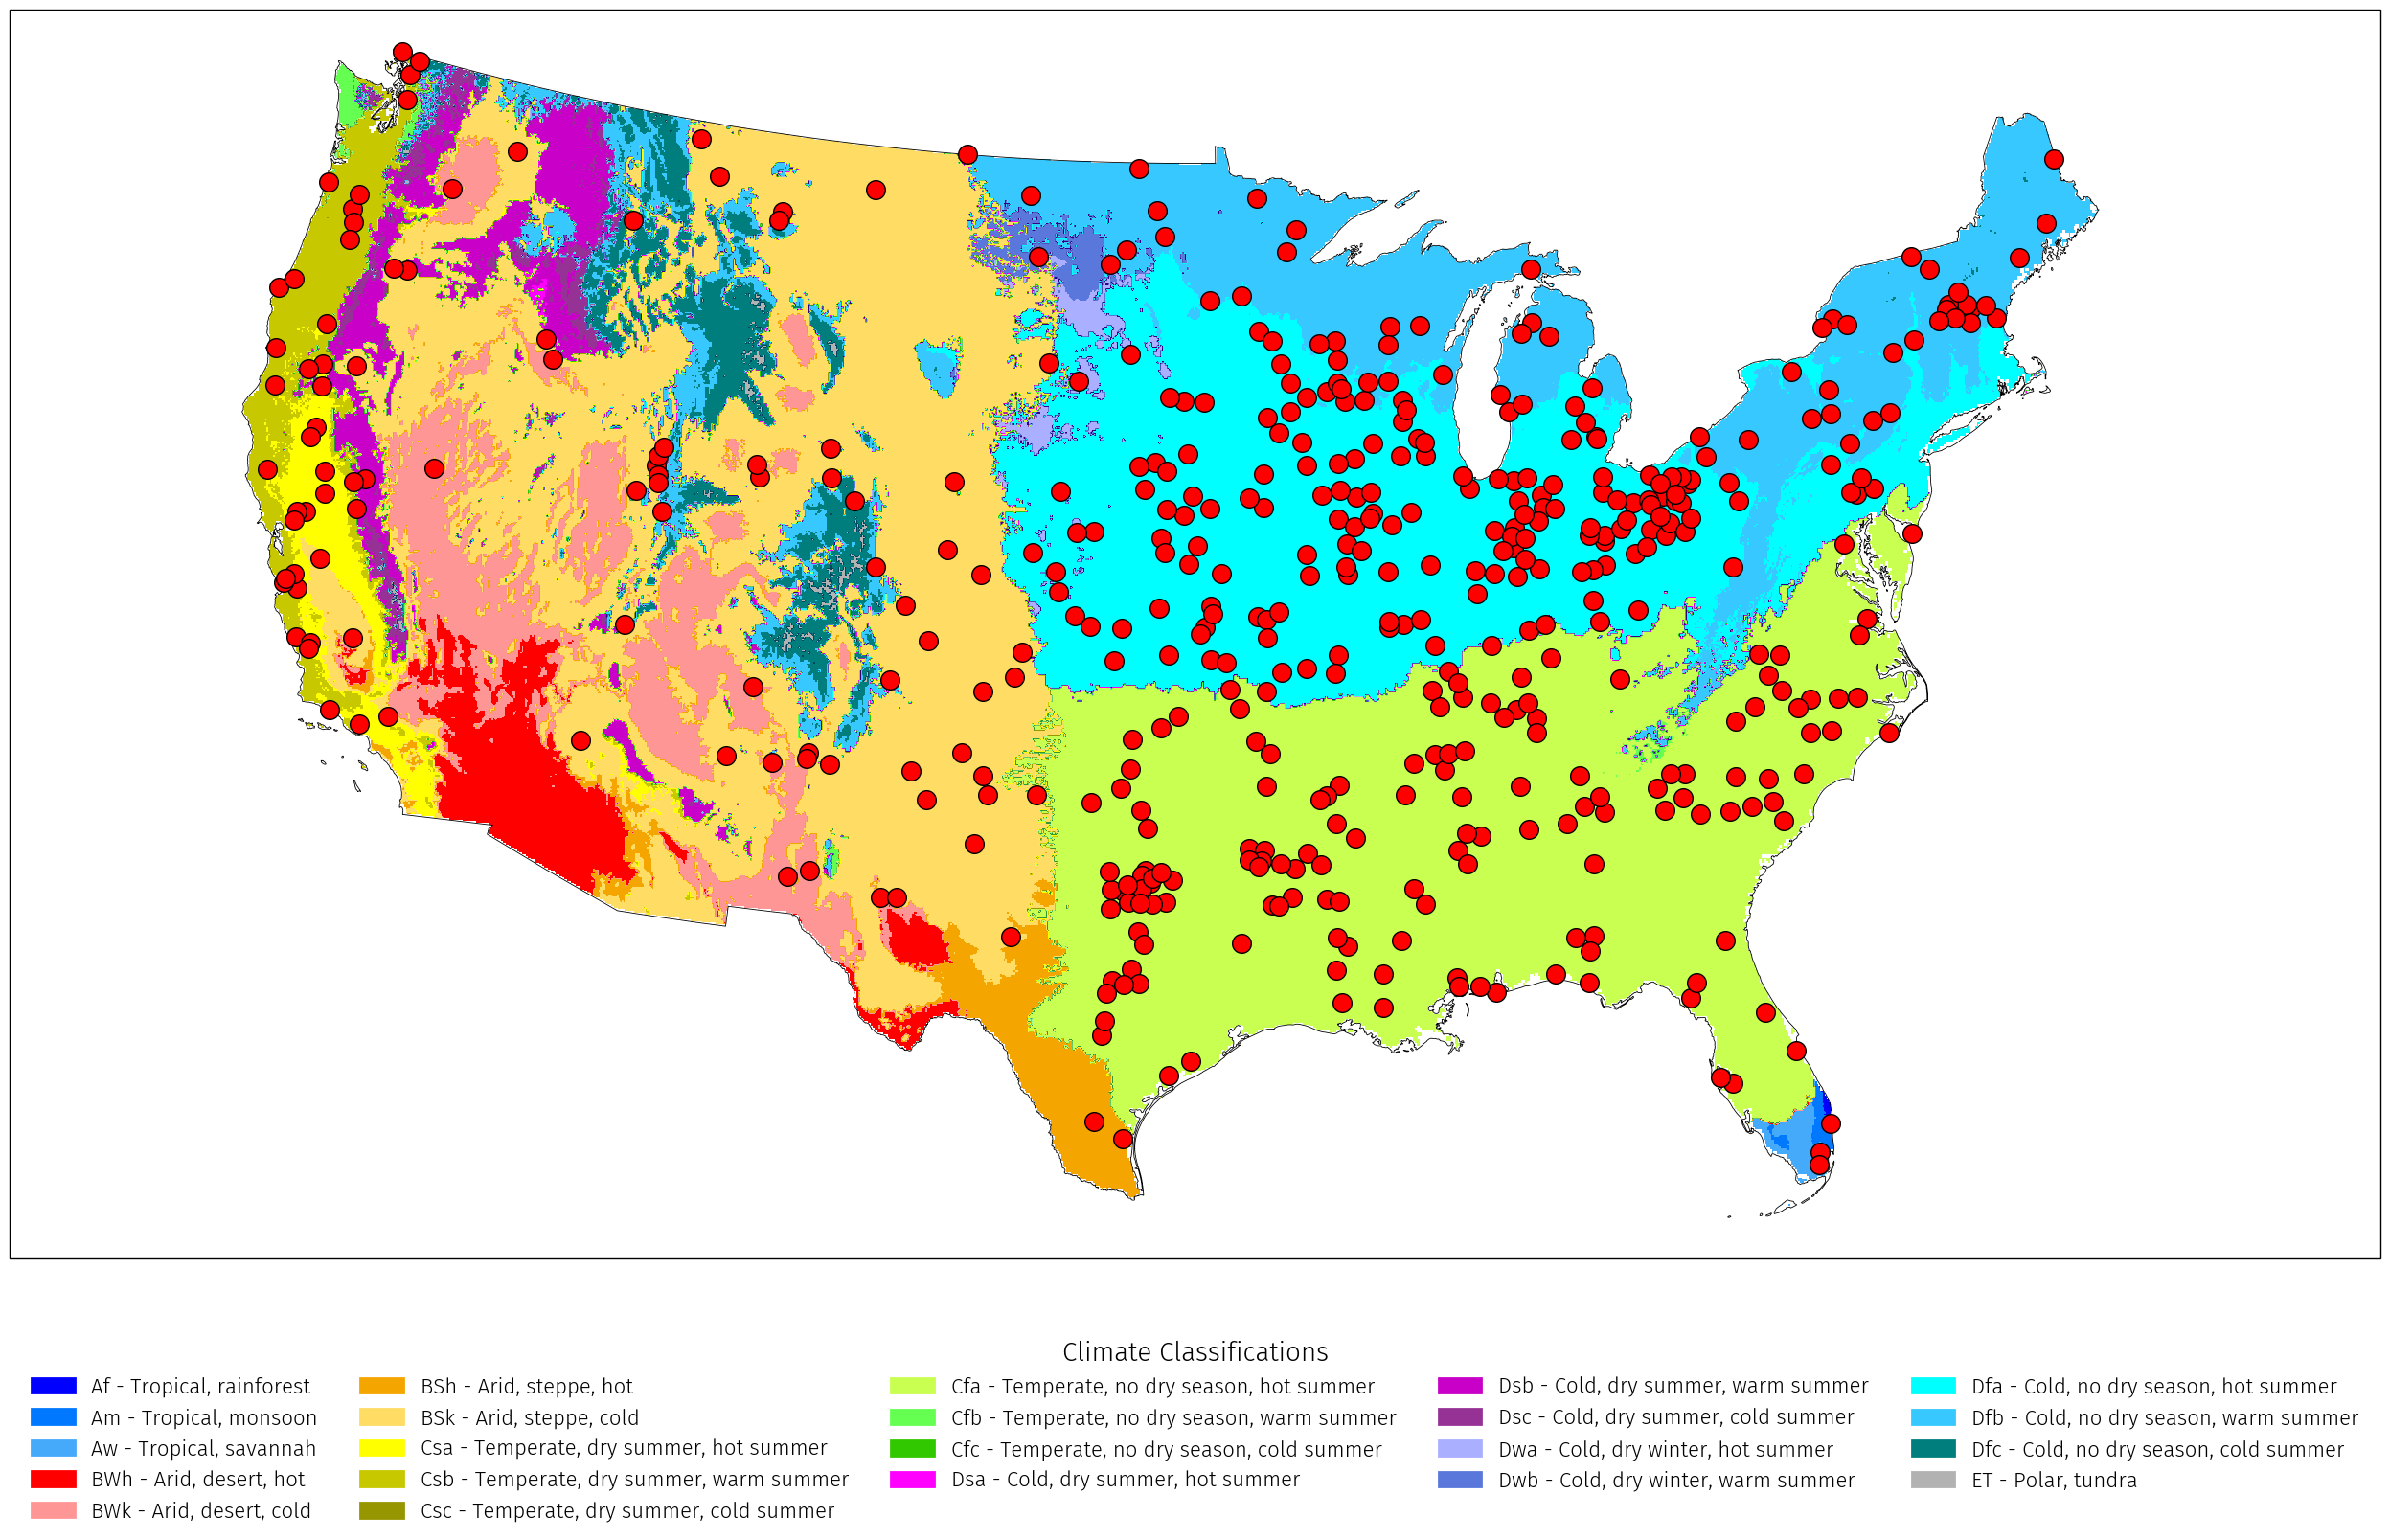

In [13]:
raster_path = "./data/CONUS_Beck_KG_V1_Present.tif"
proj_5070 = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=23, 
                                    false_easting=0.0, false_northing=0.0, 
                                    standard_parallels=(29.5, 45.5))
extent = [-125, -66.75, 24.5, 49.5]
cmap, labels, values = create_koppen_colormap()

with rasterio.open(raster_path) as src:
    data = src.read(1)
    data_masked = np.ma.masked_where(data == 0, data)
    fig, ax = plt.subplots(figsize=(14, 9), subplot_kw={'projection': proj_5070})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    im = ax.imshow(data_masked, cmap=cmap, vmin=0.5, vmax=30.5, 
                    extent=[src.bounds.left, src.bounds.right, 
                            src.bounds.bottom, src.bounds.top],
                    transform=ccrs.PlateCarree())
    
    bnd = gpd.read_file('data/shp/CONUS_boundary.shp')
    ax.add_geometries(bnd.geometry, crs=ccrs.PlateCarree(), 
                color='none', edgecolor="k", linewidth=0.3, zorder=2)
    
    # Stations
    for i, station in p_dpt_stations.iterrows():
        ax.scatter(
            x=station["Lon"],
            y=station["Lat"],
            transform=ccrs.PlateCarree(),
            edgecolors="k",
            color="red",
            s=50,
            zorder=10,
            linewidths=0.5,
        )

    # Legend
    unique_values = np.unique(data[~np.isnan(data)])
    legend_patches = []

    for val in sorted(unique_values):
        if 1 <= val <= 30:
            idx = int(val) - 1
            color = cmap.colors[idx]
            label = labels[idx]
            legend_patches.append(Patch(color=color, label=label))
    
    ax.legend(handles=legend_patches, 
                bbox_to_anchor=(0.5, -0.05), 
                loc='upper center',
                fontsize=8,
                title='Climate Classifications',
                ncol=5,
                title_fontsize=10)
    

    plt.tight_layout()
    fig.savefig(OUTPUT_PATH / "figures/stations_KG_dpt.pdf", dpi=300, format="pdf")
    plt.show()


In [14]:
kg_descriptions = {
            1: 'Af - Tropical, rainforest',
            2: 'Am - Tropical, monsoon',
            3: 'Aw - Tropical, savannah',
            4: 'BWh - Arid, desert, hot',
            5: 'BWk - Arid, desert, cold',
            6: 'BSh - Arid, steppe, hot',
            7: 'BSk - Arid, steppe, cold',
            8: 'Csa - Temperate, dry summer, hot summer',
            9: 'Csb - Temperate, dry summer, warm summer',
            10: 'Csc - Temperate, dry summer, cold summer',
            11: 'Cwa - Temperate, dry winter, hot summer',
            12: 'Cwb - Temperate, dry winter, warm summer',
            13: 'Cwc - Temperate, dry winter, cold summer',
            14: 'Cfa - Temperate, no dry season, hot summer',
            15: 'Cfb - Temperate, no dry season, warm summer',
            16: 'Cfc - Temperate, no dry season, cold summer',
            17: 'Dsa - Cold, dry summer, hot summer',
            18: 'Dsb - Cold, dry summer, warm summer',
            19: 'Dsc - Cold, dry summer, cold summer',
            20: 'Dsd - Cold, dry summer, very cold winter',
            21: 'Dwa - Cold, dry winter, hot summer',
            22: 'Dwb - Cold, dry winter, warm summer',
            23: 'Dwc - Cold, dry winter, cold summer',
            24: 'Dwd - Cold, dry winter, very cold winter',
            25: 'Dfa - Cold, no dry season, hot summer',
            26: 'Dfb - Cold, no dry season, warm summer',
            27: 'Dfc - Cold, no dry season, cold summer',
            28: 'Dfd - Cold, no dry season, very cold winter',
            29: 'ET - Polar, tundra',
            30: 'EF - Polar, frost'
        }



p_dpt_stations = extract_climate_classification(p_dpt_stations, raster_path, "Lat", "Lon")
p_dpt_stations["KG"].map(kg_descriptions).value_counts()


KG
Dfa - Cold, no dry season, hot summer          180
Cfa - Temperate, no dry season, hot summer     150
BSk - Arid, steppe, cold                        48
Dfb - Cold, no dry season, warm summer          48
Csb - Temperate, dry summer, warm summer        20
Csa - Temperate, dry summer, hot summer         14
BWk - Arid, desert, cold                        10
Am - Tropical, monsoon                           2
BSh - Arid, steppe, hot                          2
Dsa - Cold, dry summer, hot summer               2
Dsb - Cold, dry summer, warm summer              1
Dfc - Cold, no dry season, cold summer           1
Cfb - Temperate, no dry season, warm summer      1
Dwb - Cold, dry winter, warm summer              1
Aw - Tropical, savannah                          1
Name: count, dtype: int64

# Scaling Analysis

In [48]:
from src.wei_fun import wei_fit
from tqdm import tqdm
import json

OUTPUT_PATH = Path("./output/scaling_analysis_dpt/")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

STATIONS = p_dpt_stations["StnID"].values

def bin_ps_data(prcp, exg, Nbins):
    """
    Bin P-S data into bins of equal size
    Args:
    -----
    prcp: Precipitation events data without NaNs
    exg: Exogenous variable data (e.g. TMEAN) without NaNs, corresponding to the precipitation events
    """
    # dim = min(len(prcp), len(exg))
    dim = len(prcp)  # len(prcp) = len(exg)
    binsize = int(dim / Nbins)

    prcp = prcp[: binsize * Nbins]  # Truncate to fit into bins
    exg = exg[: binsize * Nbins]

    # Bin data (# Each row corresponds to each bin)
    alloc_vec = np.argsort(exg, kind="stable")
    exg_mat = exg[alloc_vec].reshape((Nbins, binsize))
    prcp_mat = prcp[alloc_vec].reshape((Nbins, binsize))
    return prcp_mat, exg_mat


def pwm_estimation(X, threshold=1):
    """
    Perform Parameter Estimation using PWM (Probability-Weighted Moments) method.

    Args:
        X (NumPy 2D array): Events matrix where each row corresponds to a bin
        thresh: Independent events > threshold are used to fit data

    Returns:
        DataFrame: with PWM parameters 'c', 'w', 'T_med'
    """
    X = X - threshold
    pwm_params = np.apply_along_axis(
        wei_fit, axis=1, arr=X, how="pwm", threshold=0
    )  # Negative values are filtered out in wei_fit
    return pwm_params


def scaling_analysis(stn_id, var, durations, threshold=1):
    if not isinstance(durations, list):
        durations = [durations]

    duration_dirs = {d: (OUTPUT_PATH / d) for d in durations}
    for path in duration_dirs.values():
        (path / var).mkdir(parents=True, exist_ok=True)

    for d in durations:
        df = pd.read_csv(
            MERGED_OE_PATH / d / (stn_id + ".csv"), index_col=0, parse_dates=True
        )

        threshold = 1
        mask = (df["PRCP"] >= 0.254)

        prcp = df[mask]["PRCP"].values
        exg = df[mask][var].values

        # Bin data
        Nbins = 20
        prcp_mat, exg_mat = bin_ps_data(prcp, exg, Nbins)

        # Fit Weibull Distribution at at each bin
        pwm_params = pwm_estimation(prcp_mat, threshold=threshold)
        exg_med = np.median(exg_mat, axis=1)

        # Normalizing parameters
        _, c_o, w_o = wei_fit(prcp - threshold, how="pwm", threshold=0)
        exg_mean = exg.mean()

        # Save results
        cw_scaling = pd.DataFrame(
            {
                "c": pwm_params[:, 1],
                "w": pwm_params[:, 2],
                f"{var}_med": exg_med,
            }
        )
        cw_scaling.to_csv(
            duration_dirs[d] / var / f"cw_scaling_{stn_id}.csv", index=False
        )

        normalization = dict(c0=c_o, w0=w_o, dpt=exg_mean)
        with open(duration_dirs[d] / var / f"cw_normalization_{stn_id}.json", "w") as f:
            json.dump(normalization, f)


def load_scaling_results(stn_id, var, duration):
    """
    Load the scaling analysis results with TMEAN as exogenous variable for a single duration
    """
    cw_scaling = pd.read_csv(OUTPUT_PATH / duration / var / f"cw_scaling_{stn_id}.csv")
    with open(
        OUTPUT_PATH / duration / var / f"cw_normalization_{stn_id}.json", "r"
    ) as f:
        normalization = json.load(f)
    return cw_scaling, normalization


def main():
    fail = []
    total_iterations = len(STATIONS) * 3  # 3 variables per station
    with tqdm(total=total_iterations) as pbar:
        for stn_id in STATIONS:
            for var in ["DPT", "W500", "VIMC"]:
                try:
                    scaling_analysis(
                        stn_id, var=var, durations=["1h", "24h"], threshold=1
                    )
                except Exception as e:
                    fail.append((stn_id, var, e))
                finally:
                    pbar.update(1)

    print(f"{len(STATIONS) - len(fail) // 3}/{len(STATIONS)} analyzed")
    if len(fail) > 0:
        for stn_id, var, e in fail:
            print(
                f"Failed to perform P-{var} scaling analysis at {stn_id} with the following Exception: {e.args[1]}"
            )

In [49]:
main()

 36%|███▌      | 215/603 [00:01<00:03, 128.40it/s]/home/santa/projects/Thermodynamic-Large-Scale/src/wei_fun.py:117: RuntimeWarning: invalid value encountered in scalar divide
  M1hat = M1hat / (n * (n - 1))
100%|██████████| 603/603 [00:04<00:00, 137.99it/s]

201/201 analyzed


# Post Processing